# Customer Analytics - Purchase Predictive Analytics

## Libraries

In [92]:
import numpy as np
import pandas as pd

# WTo segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle
# Logistic Regression module for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
# For visualization
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# Linear Regression module for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [93]:
#load data
df_purchase = pd.read_csv('/kaggle/input/fmcg-data-customers-and-purchases/purchase data.csv')

# Import Scaler
scaler = pickle.load(open('/kaggle/input/my-segmentation-pickle/scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('/kaggle/input/my-segmentation-pickle/pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('/kaggle/input/my-segmentation-pickle/kmeans_pca.pickle', 'rb'))
# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0


## Purchase probability model

In [94]:
# Y is Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [95]:
# Dependant variable is based on the average price of chocolate candy bars. 
# X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5
X.head()

,Mean_Price
0,2.044
1,2.028
2,2.028
3,2.028
4,2.030


In [96]:
# Create a Logistic Regression model
# Fit the model with our X or price and our Y or incidence
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [97]:
# The coefficients for price
# Negative signals that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.3480621]])

## Price Elasticity of Purchase Probability

In [98]:
# The prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [99]:
# Price range for which we'll examine the purchase probability.
# Choose a price range between 0.5 and 3.49, 
#  which somewhat expands the actual observed price range, 
#  which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [100]:
df_price_range = pd.DataFrame(price_range)
df_price_range

,0
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54
...,...
295,3.45
296,3.46
297,3.47
298,3.48


In [101]:
# Predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. 
# The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:, 1]

# Elasticity = beta*price*(1-P(purchase))
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [102]:
# Create price elasticities master data frame
df_price_elasticities = pd.DataFrame(price_range)
df_price_elasticities.head()

,0
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54


In [103]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096376
1,0.51,-0.100443
2,0.52,-0.104637
3,0.53,-0.108961
4,0.54,-0.113419
...,...,...
295,3.45,-8.012904
296,3.46,-8.038155
297,3.47,-8.063370
298,3.48,-8.088552


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

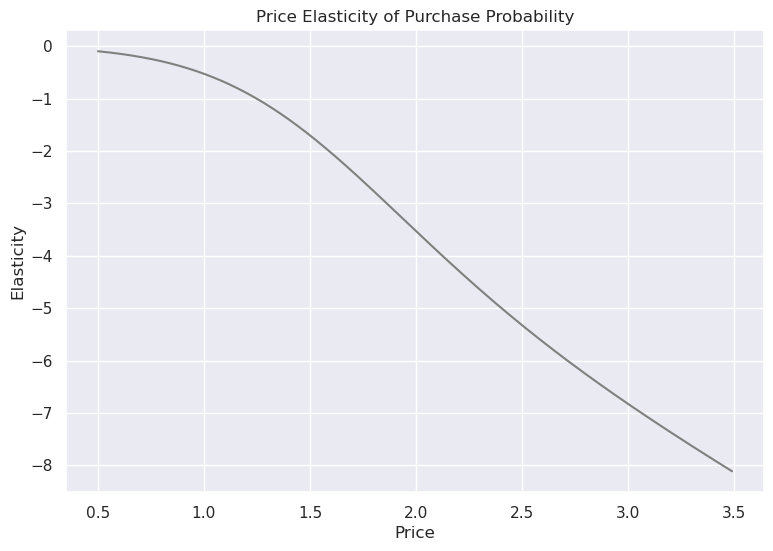

In [104]:
# Display the price elasticity of purchase probability of the average customer.
# Price elasticities are all negative. 
# Furthermore we can spot where the customer becomes inelastic when |e|=1

plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

#### Insights:
- With prices lower than 1.25, we can increase our product price without losing too much in terms of purchase probability. <br>
- For prices higher than 1.25, We have more to gain by reducing our prices.

## Purchase Probability by Segments

### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [105]:
# Filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

# Y variable is the incidence column
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()

# Calculate the average price for purchases in segment 1. 
# Dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [106]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [107]:
# The price coefficient for the career focused is -1.7, 
#   whereas for the average customer it was -2.35.
# Note: this segment is less price sensitive compared to the average customer.
model_incidence_segment_1.coef_

array([[-1.71169175]])

In [108]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Results

In [109]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_1
0,0.50,-0.096376,-0.119111
1,0.51,-0.100443,-0.123295
2,0.52,-0.104637,-0.127572
3,0.53,-0.108961,-0.131943
4,0.54,-0.113419,-0.136411
...,...,...,...
295,3.45,-8.012904,-5.680045
296,3.46,-8.038155,-5.700200
297,3.47,-8.063370,-5.720318
298,3.48,-8.088552,-5.740399


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

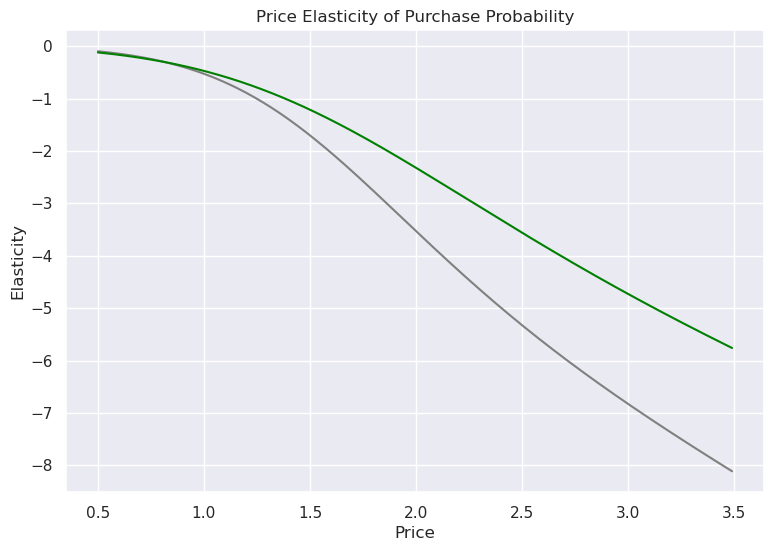

In [110]:
# Plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. 

plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 2 - Standard}}$

In [111]:
# Select only customers from segment 2, the standard.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [112]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Results

In [113]:
df_price_elasticities['PE_Segment_2'] = pe_segment2

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

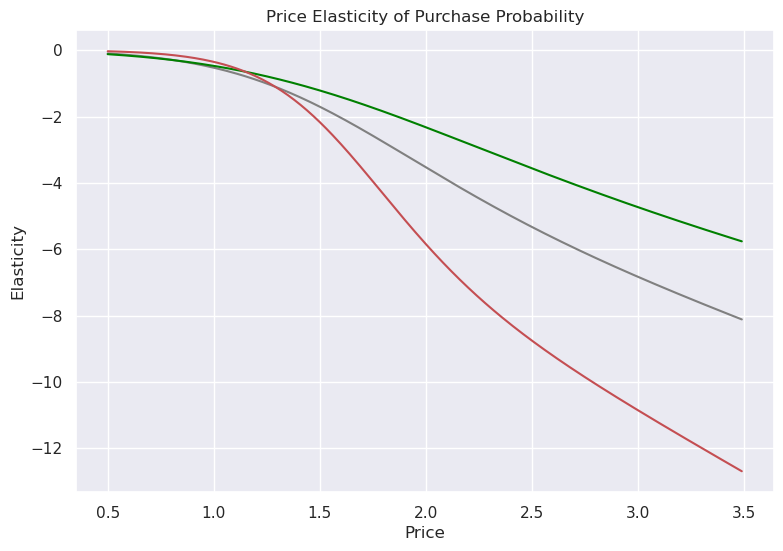

In [114]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{blue}{\text{Segment 0 - Fewer-Opportunities}}$

In [115]:
# Select only customers from segment 0, the Fewer-Opportunities segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### $\color{orange}{\text{Segment 3 - Well-Off}}$

In [116]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
# Prepare dependant and independant variables.
Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Results

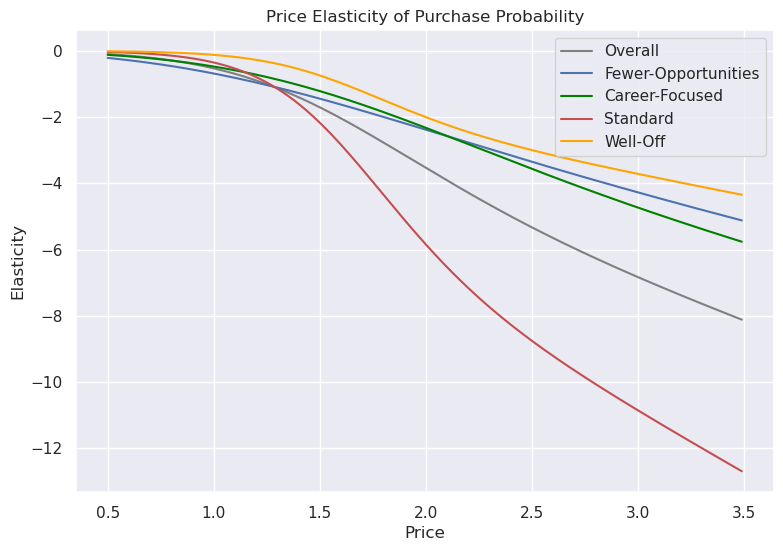

In [117]:
# Display all elasticities of purchase probability on the same plot. 

plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')
plt.legend(['Overall','Fewer-Opportunities','Career-Focused',
            'Standard','Well-Off'])

#### Insights:
- The well-off segment are the least elastic when compared to the rest. So, their purchase probability elasticity is not as affected by price. Fewer-opportunities are a lot more price-sensitive than other groups
- The price elasticities for the fewer-opportunities segment seems to differ across price range (low in low prices, high in high prices). Reasons might be:
  - We have more observations, so it is more accurate
  - This segments enjoys candy bars so much that a price increase in the low price range doesn't affect them; once it becomes expensive, it doesn't make any financial sense to them to invest in it

## Purchase Probability with Promotion Feature

### Data Preparation

In [118]:
Y = df_pa['Incidence']

X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

# Include a second promotion feature. 
#  To examine the effects of promotions on purchase probability.
# Calculate the average promotion rate across the five brands. 
#  Add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [119]:
# The coefficient for promotion is positive. 
# There is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49415323,  0.56156715]])

## Price Elasticity with Promotion

In [120]:
# Create a data frame on which our model will predict. 
# Include a price and promotion feature.
# Include the price range as the price feature. 
# Include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = \
df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [121]:
# Calculate price elasticities of purchase probability 
#   when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1
df_price_elasticity_promotion

,Price_Range,Promotion
0,0.50,1
1,0.51,1
2,0.52,1
3,0.53,1
4,0.54,1
...,...,...
295,3.45,1
296,3.46,1
297,3.47,1
298,3.48,1


In [122]:
df_price_elasticity_promotion.rename(columns={'Price_Range':'Mean_Price','Promotion':'Mean_Promotion'},inplace=True)

In [123]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [124]:
promo = Y_promotion[:, 1]

#Elasticity
price_elasticity_promo = \
(model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [125]:
# Update master data to include elasticities of purchase probability 
#  with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656
...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585


## Price Elasticity without Promotion

In [126]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = \
df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})
# Promotion feature -No Promotion.
# Assume there aren't any promotional activities on any of the price points.
# Examine the elasticity of purchase probability when there isn't promotion.
# Note: when the variables are 0 for 'Promotion', 
#   the model results won't include the impact of that variable
df_price_elasticity_promotion_no['Promotion'] = 0
df_price_elasticity_promotion_no.rename(columns={'Price_Range':'Mean_Price','Promotion':'Mean_Promotion'},inplace=True)

# Purchase Probability without Promotion Model Prediction
Y_no_promo = \
model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

no_promo = Y_no_promo[: , 1]

#Elasticity
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [127]:
# Update master data frame to include purchase probability elasticities without promotion.
# Values with and without promotion and 
#   compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732
...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349


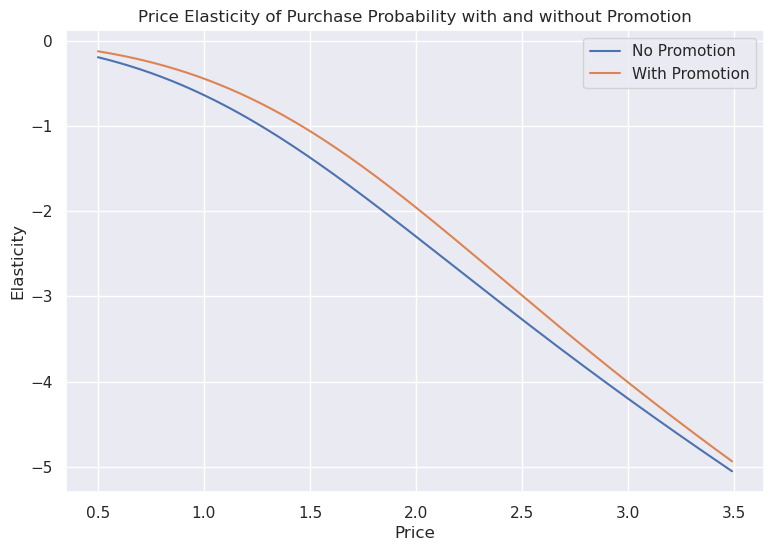

In [128]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.

plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')
plt.legend(['No Promotion','With Promotion'])

#### Insights:
- The purchase probability elasticity of the customer is less elastic when there is promotion.
- This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 

## Brand Choice

### Data preparation

In [129]:
# To determine the brand choice of the customer. 
# Filter our data, include only purchase occasion 
brand_choice = df_pa[df_pa['Incidence'] == 1]
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,2,0,0,1,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,2,0,0,1,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,2,0,0,1,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,2,0,0,1,0


In [130]:
# Set the dependent variable
Y = brand_choice['Brand']

In [131]:
# Check and decide which features to include for prediction.
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [132]:
# Predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [133]:
# Brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', 
                                        multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [134]:
# Create a pandas data frame, which contains to coefficients
#  to be reader-friendly
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915965,0.658453,2.417679,0.704078,-0.202120
1,1.274611,-1.879856,-0.212642,-0.206342,0.587872
2,1.624199,0.562118,0.500914,1.039517,0.452793
3,0.574536,0.395588,-1.400603,-1.246245,0.249353
4,0.442619,0.263697,-1.305348,-0.291009,-1.087898


In [135]:
# To increase readability:
#  transpose the data frame, to keep with the conventional representation of results.
#  add labels for the columns and the index, which represent the coefficients of the brands and prices, respectively. 
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


Interpretation: each coefficient shows how the price change would affect the probability of choosing the relative brand. In general, brand choice probability goes up if its own price is lower and other brands' prices are higher.

## Own Price Elasticity Brand 5

In [136]:
# To calculate price elasticity of brand choice
# Create a data frame with price columns, 
#  which our model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [137]:
# Brand Choice Model prediction
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)
predict_brand_5

array([[0.03290798, 0.02177645, 0.0054383 , 0.029888  , 0.90998927],
       [0.03316271, 0.02211907, 0.0055164 , 0.03025564, 0.90894618],
       [0.03341893, 0.02246675, 0.00559555, 0.03062737, 0.90789139],
       ...,
       [0.0688137 , 0.47570236, 0.0795387 , 0.23889341, 0.13705183],
       [0.06852808, 0.47748515, 0.07972902, 0.23897836, 0.13527939],
       [0.06824152, 0.47925964, 0.07991729, 0.23905586, 0.13352569]])

In [138]:
# Model returns the probabilities of choosing each of the 5 brands. 
# Only interested in the probability for the fifth brand
pr_own_brand_5 = predict_brand_5[:, 4]

In [139]:
# Choosing brand 5. 
# Get brand 5 coefficient and price 5
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [140]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [141]:
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
# pd.options.display.max_rows = 30
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478
...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058


Text(0.5, 1.0, 'Own Price Elasticity of Purchase Probability for Brand 5')

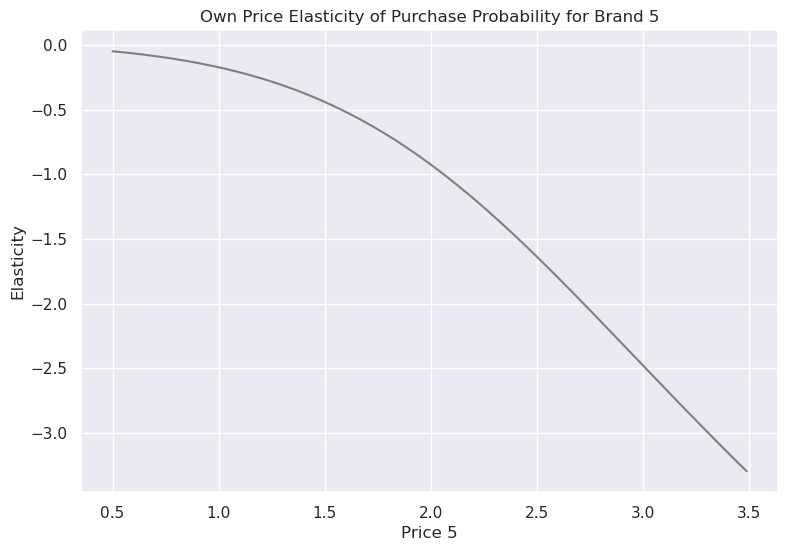

In [142]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5')

## Cross Price Elasticity Brand 5, Cross Brand 4

In [143]:
# To examine the effect of the changes in price of a competitor brand.
# The brand which comes closest to brand 5 is brand 4. 
# - Need to examine changes in the price of this brand.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [144]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [145]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [146]:
beta5

-1.09

In [147]:
# To calculate the cross brand price elasticity (with new formula)
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056,0.332011
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617,0.337287
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207,0.342507
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827,0.347668
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478,0.352773
...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573,0.162232
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767,0.160332
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929,0.158446
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058,0.156575


Text(0.5, 1.0, 'Cross Price Elasticity of Brand 5 wrt Brand 4')

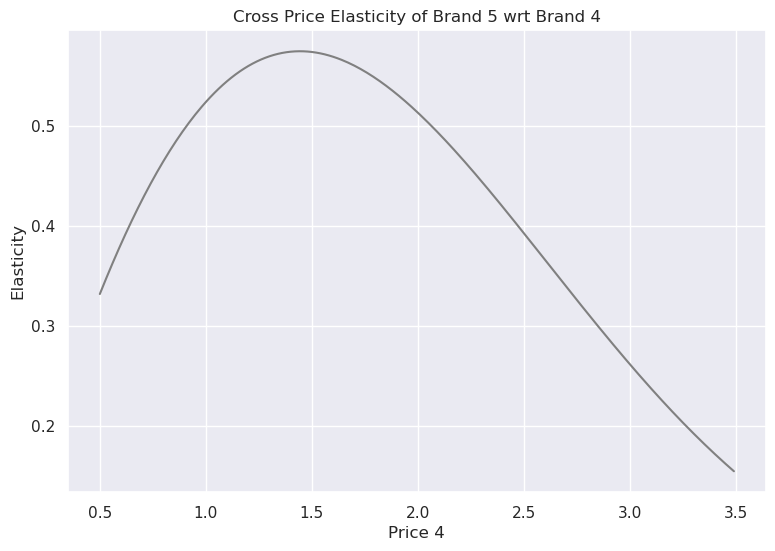

In [148]:
# Examine the cross price elasticity of purchase probability for 
#  brand 5 vs brand 4.

plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4')

🔶 Insights:
- Brand 4 is a strong substitute for brand 5 for all prices up to \$1.65
  - Note: the observed price range of brand 4 lies between \$1.76 and \$2.6 in this region
  - These prices are out of the natural domain of brand 4, therefore if brand 4 had a substantially lower price it would be a very strong competitor a brand 5
- Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, signaling that the increase in purchase probability for brand 5 happens more slowly.
  - When it comes to average customer, brand 4 is a weak substitute for brand 5 
  - Brand 5 can create a marketing strategy targeting customers who choose brand 4, and attract them to buy own brand 5

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [149]:
# Analyze the purchase probability for choosing brand 5 by segments.
# Filter our data
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 3]
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,3,0,0,0,1
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,3,0,0,0,1
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,3,0,0,0,1
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,3,0,0,0,1
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57346,200000489,687,1,4,1,4,1,1.50,1.87,2.06,...,44,2,193816,2,1,3,0,0,0,1
57347,200000489,693,1,4,2,4,1,1.42,1.51,2.02,...,44,2,193816,2,1,3,0,0,0,1
57348,200000489,701,1,4,3,4,1,1.42,1.85,1.99,...,44,2,193816,2,1,3,0,0,0,1
57350,200000489,715,1,4,2,0,0,1.50,1.80,2.09,...,44,2,193816,2,1,3,0,0,0,1


In [150]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features] #Price_1 - Price_5
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients] #Naming columns
bc_coef.index = [prices] #Naming indices
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [151]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [152]:
# Calculating cross-brand price elasticity for 
#  brand 5 vs brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to newly obtained elasticity
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = 30
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056,0.332011,-0.297309,0.482421
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617,0.337287,-0.303355,0.491726
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207,0.342507,-0.309411,0.501016
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827,0.347668,-0.315478,0.510290
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478,0.352773,-0.321556,0.519548
...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573,0.162232,-3.337315,0.157471
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767,0.160332,-3.350645,0.152049
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929,0.158446,-3.363973,0.146793
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058,0.156575,-3.377296,0.141698


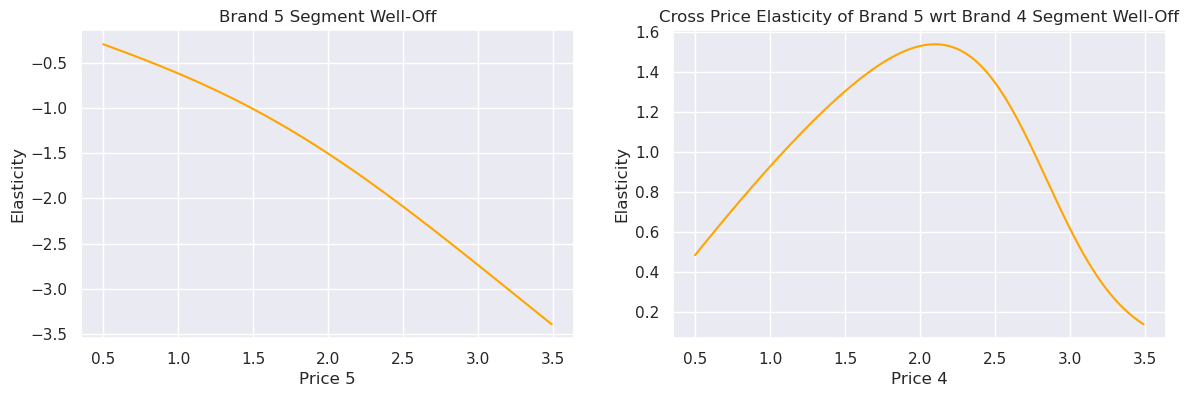

In [153]:
# Using a figure with axes 
#  we plot the own brand and cross-brand price elasticities for 
#  brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

### $\color{blue}{\text{Fewer-Opportunities}}$

In [154]:
# Analysing the brand choice probability of the 'Fewer-Opportunities' segment.
# Filter our data
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 0]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,0,1,0,0,0
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,0,1,0,0,0
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,0,1,0,0,0
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,0,1,0,0,0
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,0,1,0,0,0


In [155]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [156]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-Opportunities segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [157]:
# Calculate cross-brand price elasticity for brand 5 vs brand 4 for the Fewer-Opportunities segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# Use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [158]:
# Filter data by the 'Career-focused segment'
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [159]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [160]:
# Calculate own-brand price elasticity for brand 5 and the 'Career-focused' segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

# Compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [161]:
# Calculate cross-brand price elasticity for brand 5 vs brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', 
                             value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Standard}}$

In [162]:
# Filter data
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [163]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [164]:
# Calculate own-brand price elasticity for brand 5 and the 'Standard' segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [165]:
# Calculate cross-brand price elasticity for brand 5 vs brand 4 for the standard segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056,0.332011,-0.115857,0.174139,-0.043940,0.194770,-0.001036,0.181595,-0.297309,0.482421
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617,0.337287,-0.118897,0.176195,-0.045027,0.197254,-0.001098,0.183892,-0.303355,0.491726
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207,0.342507,-0.121971,0.178200,-0.046123,0.199687,-0.001163,0.186140,-0.309411,0.501016
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827,0.347668,-0.125080,0.180154,-0.047229,0.202069,-0.001231,0.188340,-0.315478,0.510290
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478,0.352773,-0.128226,0.182057,-0.048343,0.204401,-0.001303,0.190491,-0.321556,0.519548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573,0.162232,-3.592447,0.024050,-1.287426,0.068594,-3.746081,0.023408,-3.337315,0.157471
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767,0.160332,-3.606351,0.023694,-1.297235,0.067971,-3.757523,0.022948,-3.350645,0.152049
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929,0.158446,-3.620211,0.023342,-1.307099,0.067352,-3.768945,0.022495,-3.363973,0.146793
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058,0.156575,-3.634028,0.022995,-1.317018,0.066738,-3.780347,0.022050,-3.377296,0.141698


Text(0.5, 0, 'Price 4')

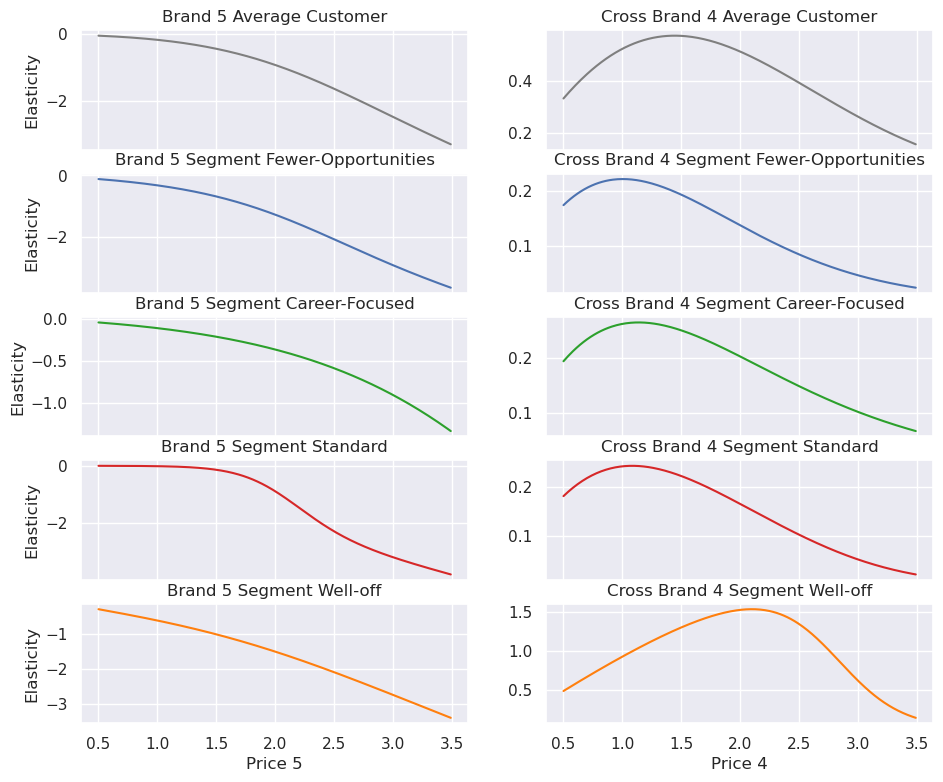

In [166]:
# Plot the own and cross brand price elasticities for 
#  the average customer and each of the four segments.

fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Standard')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Standard')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')

🔶 Insights: Brand 5 should decrease its own price offering while gaining solid market share from the well-off and retaining the career-focused segment, the most frequent buyers of brand 5
- For Career-focused segment, Brand 5 could increase its price, without fear of significant loss of customers from this segment
  - The Career-focused segment is the most inelastic and they do not seem to be that affected by price
  - The cross price elasticity also has extremely low values, meaning they are unlikely to switch to brand 4
- For the Well-off segment, we'd better decrease brand 5 price to gain market share from this segment
  - For this segment, own elasticity is much higher than 'career-focused'
  - They also purchase the competitor brand 4 most often by having highest cross brand elasticity, meaning a tiny increase in price will lose customers

## Price Elasticity of Purchase Quantity

In [167]:
# To determine price elasticity of purchase quantity, 
#   also known as price elasticity of demand.
# Interested in purchase ocassion, where the purchased quantity is different from 0.
# Filter our data
df_purchase_quantity = df_pa[df_pa['Incidence'] == 1]
df_purchase_quantity.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [168]:
# Create brand dummies, for each of the five brands.
df_purchase_quantity = pd.get_dummies(df_purchase_quantity, 
                                      columns = ['Brand'], 
                                      prefix = 'Brand', prefix_sep = '_')
# Descriptive analysis: 
#  - quantity ranges from 1 to 15 
#  - average value of 2.8, 
#    which means that more often than not our customers buy more than 1 chocolate candy bar.
df_purchase_quantity.describe()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment,Segment_0,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
count,1.463800e+04,14638.000000,14638.0,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,...,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000,14638.000000
mean,2.000003e+08,359.607597,1.0,2.774559,1.535251,0.406955,1.384559,1.764717,2.006694,2.159658,...,1.581910,0.175229,0.299290,0.293824,0.231657,0.092226,0.310288,0.057453,0.199959,0.340074
std,1.423786e+02,205.346253,0.0,1.796736,2.060858,0.491283,0.090944,0.181667,0.046200,0.093253,...,1.028171,0.380176,0.457962,0.455528,0.421906,0.289354,0.462627,0.232714,0.399983,0.473750
min,2.000000e+08,1.000000,1.0,1.000000,0.000000,0.000000,1.100000,1.260000,1.870000,1.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000001e+08,175.000000,1.0,2.000000,0.000000,0.000000,1.340000,1.570000,1.970000,2.120000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000003e+08,355.000000,1.0,2.000000,0.000000,0.000000,1.390000,1.880000,2.010000,2.180000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000004e+08,532.000000,1.0,3.000000,4.000000,1.000000,1.470000,1.890000,2.060000,2.240000,...,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.000005e+08,727.000000,1.0,15.000000,5.000000,1.000000,1.590000,1.900000,2.140000,2.260000,...,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
# Decide on which features to include in our model -> Price & Promotion
df_purchase_quantity.columns.values

array(['ID', 'Day', 'Incidence', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3', 'Brand_1',
       'Brand_2', 'Brand_3', 'Brand_4', 'Brand_5'], dtype=object)

In [170]:
#Find the price of the product that is chosen at this incidence
df_purchase_quantity['Price_Incidence'] = \
(df_purchase_quantity['Brand_1'] * df_purchase_quantity['Price_1'] +
 df_purchase_quantity['Brand_2'] * df_purchase_quantity['Price_2'] +
 df_purchase_quantity['Brand_3'] * df_purchase_quantity['Price_3'] +
 df_purchase_quantity['Brand_4'] * df_purchase_quantity['Price_4'] +
 df_purchase_quantity['Brand_5'] * df_purchase_quantity['Price_5'] )

In [171]:
#Find the whether a promotion was run at this incidence
df_purchase_quantity['Promotion_Incidence'] = \
(df_purchase_quantity['Brand_1'] * df_purchase_quantity['Promotion_1'] +
 df_purchase_quantity['Brand_2'] * df_purchase_quantity['Promotion_2'] +
 df_purchase_quantity['Brand_3'] * df_purchase_quantity['Promotion_3'] +
 df_purchase_quantity['Brand_4'] * df_purchase_quantity['Promotion_4'] +
 df_purchase_quantity['Brand_5'] * df_purchase_quantity['Promotion_5'] )

In [172]:
df_purchase_quantity.head()

,ID,Day,Incidence,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,...,Segment_1,Segment_2,Segment_3,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5,Price_Incidence,Promotion_Incidence
6,200000001,28,1,2,0,0,1.50,1.90,1.99,2.09,...,0,1,0,0,1,0,0,0,1.90,0
11,200000001,58,1,1,0,0,1.39,1.90,1.91,2.12,...,0,1,0,0,0,0,0,1,2.62,1
19,200000001,110,1,2,0,0,1.47,1.90,1.99,1.97,...,0,1,0,1,0,0,0,0,1.47,0
24,200000001,142,1,1,0,0,1.21,1.35,1.99,2.16,...,0,1,0,0,0,0,1,0,2.16,0
29,200000001,183,1,3,0,0,1.46,1.88,1.97,1.89,...,0,1,0,0,1,0,0,0,1.88,0


In [173]:
# pd.options.display.max_rows = 30

## Model Estimation: Linear Regression

In [174]:
X = df_purchase_quantity[['Price_Incidence', 'Promotion_Incidence']]
X

,Price_Incidence,Promotion_Incidence
6,1.90,0
11,2.62,1
19,1.47,0
24,2.16,0
29,1.88,0
...,...,...
58621,1.89,0
58648,1.35,1
58674,1.85,1
58687,1.51,0


In [175]:
Y = df_purchase_quantity['Quantity']
Y.head()

6     2
11    1
19    2
24    1
29    3
Name: Quantity, dtype: int64

In [176]:
# Linear Regression Model
model_quantity = LinearRegression()
model_quantity.fit(X, Y)

LinearRegression()

In [177]:
# It appears that promotion reflects negatively on the 
#  purchase quantity of the average client, which is unexpected.
model_quantity.coef_ 
# 1- Price_incidence 2- Promotion_incidence

array([-0.8173651 , -0.10504673])

## Price Elasticity with Promotion

In [178]:
# Examine the price elasticity of purchase quantity 
#  with active promotional activities for each price point.
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Promotion_Incidence'] = 1

In [179]:
df_price_elasticity_quantity

,Price_Incidence,Promotion_Incidence
0,0.50,1
1,0.51,1
2,0.52,1
3,0.53,1
4,0.54,1
...,...,...
295,3.45,1
296,3.46,1
297,3.47,1
298,3.48,1


In [180]:
#Take the coefficient for price.
beta_quantity = model_quantity.coef_[0]
beta_quantity

-0.8173651016684991

In [181]:
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

In [182]:
# Calculate the price elasticity with new formula. 
price_elasticity_quantity_promotion_yes = \
beta_quantity * price_range / predict_quantity

In [183]:
df_price_elasticities['PE_Quantity_Promotion_1'] = \
price_elasticity_quantity_promotion_yes
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056,0.332011,-0.115857,0.174139,-0.043940,0.194770,-0.001036,0.181595,-0.297309,0.482421,-0.102157
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617,0.337287,-0.118897,0.176195,-0.045027,0.197254,-0.001098,0.183892,-0.303355,0.491726,-0.104413
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207,0.342507,-0.121971,0.178200,-0.046123,0.199687,-0.001163,0.186140,-0.309411,0.501016,-0.106679
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827,0.347668,-0.125080,0.180154,-0.047229,0.202069,-0.001231,0.188340,-0.315478,0.510290,-0.108954
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478,0.352773,-0.128226,0.182057,-0.048343,0.204401,-0.001303,0.190491,-0.321556,0.519548,-0.111238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573,0.162232,-3.592447,0.024050,-1.287426,0.068594,-3.746081,0.023408,-3.337315,0.157471,-1.774292
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767,0.160332,-3.606351,0.023694,-1.297235,0.067971,-3.757523,0.022948,-3.350645,0.152049,-1.788634
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929,0.158446,-3.620211,0.023342,-1.307099,0.067352,-3.768945,0.022495,-3.363973,0.146793,-1.803124
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058,0.156575,-3.634028,0.022995,-1.317018,0.066738,-3.780347,0.022050,-3.377296,0.141698,-1.817766


Text(0.5, 1.0, 'Price Elasticity of Purchase Quantity with Promotion')

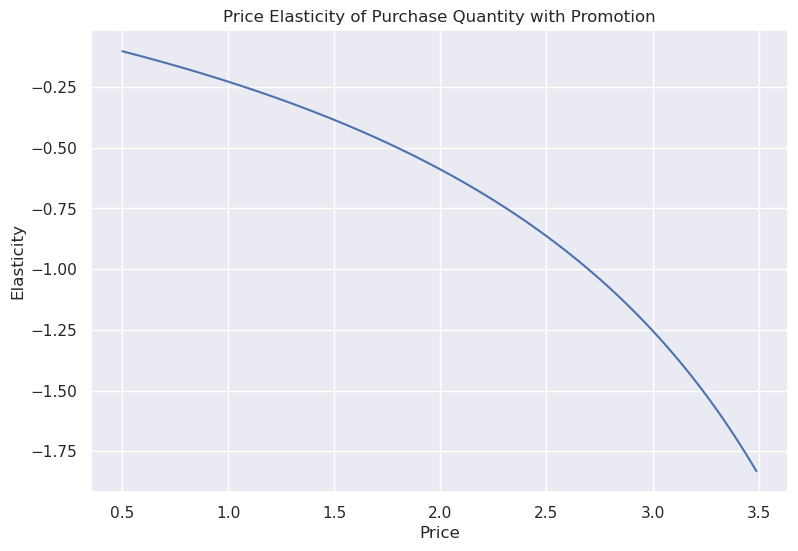

In [184]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')

## Price Elasticity without Promotion

In [185]:
# Overwrite promotion incidence in order to use the same df. 
# A ssume there are no promotinal activities active for the entire price range.
df_price_elasticity_quantity['Promotion_Incidence'] = 0
# Find the new predicted quantities.
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)
# Calculate the new price elasticities.
price_elasticity_quantity_promotion_no = beta_quantity * price_range / predict_quantity
# Add the results to the master data frame.
df_price_elasticities['PE_Quantity_Promotion_0'] = price_elasticity_quantity_promotion_no
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3,PE_Quantity_Promotion_1,PE_Quantity_Promotion_0
0,0.50,-0.096376,-0.211181,-0.119111,-0.030902,-0.010574,-0.125715,-0.195629,-0.049056,0.332011,-0.115857,0.174139,-0.043940,0.194770,-0.001036,0.181595,-0.297309,0.482421,-0.102157,-0.099543
1,0.51,-0.100443,-0.217751,-0.123295,-0.032668,-0.011178,-0.129831,-0.201750,-0.050617,0.337287,-0.118897,0.176195,-0.045027,0.197254,-0.001098,0.183892,-0.303355,0.491726,-0.104413,-0.101736
2,0.52,-0.104637,-0.224428,-0.127572,-0.034521,-0.011812,-0.134026,-0.207974,-0.052207,0.342507,-0.121971,0.178200,-0.046123,0.199687,-0.001163,0.186140,-0.309411,0.501016,-0.106679,-0.103939
3,0.53,-0.108961,-0.231214,-0.131943,-0.036465,-0.012477,-0.138300,-0.214301,-0.053827,0.347668,-0.125080,0.180154,-0.047229,0.202069,-0.001231,0.188340,-0.315478,0.510290,-0.108954,-0.106150
4,0.54,-0.113419,-0.238110,-0.136411,-0.038503,-0.013175,-0.142656,-0.220732,-0.055478,0.352773,-0.128226,0.182057,-0.048343,0.204401,-0.001303,0.190491,-0.321556,0.519548,-0.111238,-0.108369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,3.45,-8.012904,-5.050647,-5.680045,-12.542872,-4.291841,-4.862066,-4.983686,-3.231573,0.162232,-3.592447,0.024050,-1.287426,0.068594,-3.746081,0.023408,-3.337315,0.157471,-1.774292,-1.664290
296,3.46,-8.038155,-5.067500,-5.700200,-12.579793,-4.304474,-4.880270,-5.000593,-3.247767,0.160332,-3.606351,0.023694,-1.297235,0.067971,-3.757523,0.022948,-3.350645,0.152049,-1.788634,-1.677205
297,3.47,-8.063370,-5.084335,-5.720318,-12.616696,-4.317101,-4.898443,-5.017481,-3.263929,0.158446,-3.620211,0.023342,-1.307099,0.067352,-3.768945,0.022495,-3.363973,0.146793,-1.803124,-1.690246
298,3.48,-8.088552,-5.101151,-5.740399,-12.653583,-4.329723,-4.916585,-5.034349,-3.280058,0.156575,-3.634028,0.022995,-1.317018,0.066738,-3.780347,0.022050,-3.377296,0.141698,-1.817766,-1.703414


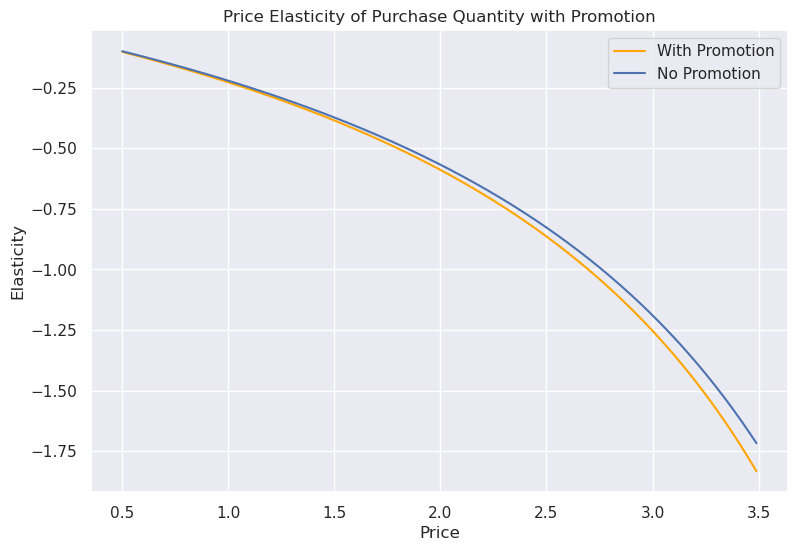

In [186]:
# Plot the two elasticities side by side. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_quantity_promotion_yes, color = 'orange')
plt.plot(price_range, price_elasticity_quantity_promotion_no)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Quantity with Promotion')
plt.legend(['With Promotion','No Promotion'])

#### Insights:
- We observe that the two elasticities are very close together for almost the entire price range.
- It appears that promotion does not appear to be a significant factor in the customers' decission what quantity of chocolate candy bars to purchase.